<a href="https://colab.research.google.com/github/RicoBasyar/Word-Embedding-Effects-in-Indonesian-Social-Media-LSTM/blob/main/Word2Vec/Cyberbullying_LSTM_Word2vec_32_UNIT_200_EPOCHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sastrawi

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import string, re
from wordcloud import WordCloud
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import nltk

from gensim.models import Word2Vec

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Dataset**

In [ ]:
df = pd.read_csv('result_df.csv')

In [ ]:
df = df.dropna()

In [ ]:
df = df.drop(0)

df = df.reset_index(drop=True)

In [ ]:
df

,label,Komentar
0,0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,0,RT @baguscondromowo: Mereka terus melukai aksi...
2,0,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,0,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,0,RT @lisdaulay28: Waspada KTP palsu.....kawal P...
...,...,...
1758,0,Bangga sama suami yg selalu ingat istri disela...
1759,0,Apaoun pekerjaannya yg penting halal u tuk men...
1760,0,Gojek itu mayoritas pegangguran yang lama gak ...
1761,0,<USERNAME> aslinya cantik dan ayu loh mbak kr...


In [ ]:
print(df.label.value_counts())
plot = df.label.value_counts()
px.bar(plot)

0    978
1    785
Name: label, dtype: int64


In [ ]:
class_counts = df.label.value_counts()

min_samples = class_counts.min()

df_label_0 = df[df['label'] == 0].sample(n=min_samples, random_state=42)

df_label_1 = df[df['label'] == 1]

balanced_df = pd.concat([df_label_0, df_label_1])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df)

      label                                           Komentar
0         1  Sedih ya skrg ngamen di kawinan org .. mantan ...
1         1  iya,kelasnya penista agama,bs nya cm ngebacot ...
2         0  mrinding... bagus poll... d jaga ya dek kepolo...
3         1  #MataNajwaDebatJakarta pak anies banyak omdo d...
4         1                   "ANJING SINI LO BAKU HANTAM AYO"
...     ...                                                ...
1565      1  "Perasaan kemarin lengannya kekar banget kek p...
1566      1  "Cocok banget sama2 orang gak bener biar lah d...
1567      1            Bajingan lu silvy #DebatFinalPilkadaJKT
1568      1  Biarin,,,puas puasin mumpung deseu masih brasa...
1569      1   "Ya ampun ketiak dan lemaknya editan parah wkwk"

[1570 rows x 2 columns]


In [ ]:
print(balanced_df.label.value_counts())
plot = balanced_df.label.value_counts()
px.bar(plot)

1    785
0    785
Name: label, dtype: int64


In [ ]:
df = balanced_df

In [ ]:
print(df.label.value_counts())

1    785
0    785
Name: label, dtype: int64


# **Data Preprocessing**

## **Cleneaning Data**

In [ ]:
def data_cleansing(text):
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'RT @\w+: ', '', text)
  text = re.sub(r'http\S+', '', text)
  text = text.lower()
  text = text.replace('username',' ')
  tb = string.punctuation
  trans = str.maketrans(tb,' '*len(tb))
  text = text.translate(trans)
  text = text.encode('ascii','ignore').decode('utf-8')
  text = re.sub(r'[^\x00-\x7f]',r'', text)
  text = text.replace('\n',' ')
  text = re.sub(r"\d+", "", text)
  return text

In [ ]:
df['Komentar'] = df['Komentar'].apply(data_cleansing)

In [ ]:
df

,label,Komentar,Komentar.tokenize,Komentar.tokenize.text
0,1,sedih ngamen kawin mantan istri mahhhh pesawat...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[sedih, ngamen, kawin, mantan, istri, mahhhh, ..."
1,1,kelas nista agama ngebacot arogan sk bilang ta...,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...","[kelas, nista, agama, ngebacot, arogan, sk, bi..."
2,0,mrinding bagus poll dek polos smpek aw dkk,"[30, 31, 32, 33, 34, 35, 36, 37]","[mrinding, bagus, poll, dek, polos, smpek, aw,..."
3,1,omdo menteri terobos bicara ky jago,"[38, 39, 40, 41, 42, 43]","[omdo, menteri, terobos, bicara, ky, jago]"
4,1,anjing baku hantam ayo,"[44, 45, 46, 47]","[anjing, baku, hantam, ayo]"
...,...,...,...,...
1565,1,asa kemarin lengan kekar tinju ketiak hitam fo...,"[217, 221, 678, 4071, 4072, 228, 94, 47, 678, ...","[asa, kemarin, lengan, kekar, tinju, ketiak, h..."
1566,1,cocok biar hancur,"[179, 12, 292]","[cocok, biar, hancur]"
1567,1,bajing silvy,"[4074, 167]","[bajing, silvy]"
1568,1,biarin puas puasin mumpung deseu asa muda tua ...,"[617, 881, 4075, 1509, 4076, 195, 148, 133, 40...","[biarin, puas, puasin, mumpung, deseu, asa, mu..."


## **Ubah Singkatan**

In [ ]:
singkatan = pd.read_csv('kamus_singkatan.csv')
singkatan = singkatan.drop('Unnamed: 0', axis=1)

In [ ]:
singkatan

,singkatan,asli
0,abgny,abangnya
1,abis,habis
2,ad,ada
3,adek,adik
4,adik2,adik-adik
...,...,...
1498,trm,terima
1499,tukeran,tukar
1500,tw,tahu
1501,yup,ya


In [ ]:
new_row = [{'singkatan': 'in', 'asli': 'ini'},
            {'singkatan': 'ajg', 'asli': 'anjing'},
           {'singkatan': 'capek2', 'asli': 'capek capek'},
           {'singkatan': 'dimana2', 'asli': 'dimana mana'},
           {'singkatan': 'om2', 'asli': 'om om'},
           {'singkatan': 'bayi2', 'asli': 'bayi bayi'},
           {'singkatan': 'cakep2', 'asli': 'cakep cakep'}]
singkatan = singkatan.append(new_row, ignore_index=True)

<ipython-input-46-e60c46460bea>:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
singkatan

,singkatan,asli
0,abgny,abangnya
1,abis,habis
2,ad,ada
3,adek,adik
4,adik2,adik-adik
...,...,...
1505,capek2,capek capek
1506,dimana2,dimana mana
1507,om2,om om
1508,bayi2,bayi bayi


In [ ]:
singkatan_dict = dict(zip(singkatan['singkatan'], singkatan['asli']))

def ubah_singkatan(text):
    for a, b in singkatan_dict.items():
        pattern = r"\b" + re.escape(a) + r"\b"
        text = re.sub(pattern, b, text)
    return text

In [ ]:
df['Komentar'] = df['Komentar'].apply(ubah_singkatan)

In [ ]:
df

,label,Komentar,Komentar.tokenize,Komentar.tokenize.text
0,1,sedih ngamen kawin mantan istri mahhhh pesawat...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[sedih, ngamen, kawin, mantan, istri, mahhhh, ..."
1,1,kelas nista agama ngebacot arogan sk bilang ta...,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...","[kelas, nista, agama, ngebacot, arogan, sk, bi..."
2,0,mrinding bagus poll dek polos smpek aw dkk,"[30, 31, 32, 33, 34, 35, 36, 37]","[mrinding, bagus, poll, dek, polos, smpek, aw,..."
3,1,omdo menteri terobos bicara ky jago,"[38, 39, 40, 41, 42, 43]","[omdo, menteri, terobos, bicara, ky, jago]"
4,1,anjing baku hantam ayo,"[44, 45, 46, 47]","[anjing, baku, hantam, ayo]"
...,...,...,...,...
1565,1,asa kemarin lengan kekar tinju ketiak hitam fo...,"[217, 221, 678, 4071, 4072, 228, 94, 47, 678, ...","[asa, kemarin, lengan, kekar, tinju, ketiak, h..."
1566,1,cocok biar hancur,"[179, 12, 292]","[cocok, biar, hancur]"
1567,1,bajing silvy,"[4074, 167]","[bajing, silvy]"
1568,1,biarin puas puasin mumpung deseu asa muda tua ...,"[617, 881, 4075, 1509, 4076, 195, 148, 133, 40...","[biarin, puas, puasin, mumpung, deseu, asa, mu..."


## **Stopword**

In [ ]:
def tambah_stopword():
  tambah_stopword = pd.read_csv('stopwordbahasa.csv', header=None)
  tambah_stopword
  tambah_stopword_list = tambah_stopword.values.flatten().tolist()
  return tambah_stopword_list

In [ ]:
factory=StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [ ]:
def stopwords(text):
  tambahlagi = ['nya','kak','si','bang','arti', 'deh','eh','sih','sok','kek','ahok', 'basuki', 'hahaha', 'tuh', 'ih', 'mel', 'tenar'
  , 'jakarta','mbak','mba','eh','moga','pakai','pilih','anies','pilih','kali','pakai','loh','mah'
  ,'haha','mah','jaga','ni','ko','kok','wkwk','pilkada','pimpin','nagita','iya','jaga','btp','orang','kena','om','elu']
  regex = r'\b(?:{})\b'.format('|'.join(map(re.escape, tambah_stopword()+tambahlagi)))
  text = re.sub(regex, '', text)
  text = stopword.remove(text)
  return text

In [ ]:
df['Komentar'] = df['Komentar'].apply(stopwords)

In [ ]:
df

,label,Komentar,Komentar.tokenize,Komentar.tokenize.text
0,1,sedih ngamen kawin mantan istri mahhhh pesawat...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[sedih, ngamen, kawin, mantan, istri, mahhhh, ..."
1,1,kelas nista agama ngebacot arogan sk bilang ta...,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...","[kelas, nista, agama, ngebacot, arogan, sk, bi..."
2,0,mrinding bagus poll dek polos smpek aw dkk,"[30, 31, 32, 33, 34, 35, 36, 37]","[mrinding, bagus, poll, dek, polos, smpek, aw,..."
3,1,omdo menteri terobos bicara ky jago,"[38, 39, 40, 41, 42, 43]","[omdo, menteri, terobos, bicara, ky, jago]"
4,1,anjing baku hantam ayo,"[44, 45, 46, 47]","[anjing, baku, hantam, ayo]"
...,...,...,...,...
1565,1,asa kemarin lengan kekar tinju ketiak hitam fo...,"[217, 221, 678, 4071, 4072, 228, 94, 47, 678, ...","[asa, kemarin, lengan, kekar, tinju, ketiak, h..."
1566,1,cocok biar hancur,"[179, 12, 292]","[cocok, biar, hancur]"
1567,1,bajing silvy,"[4074, 167]","[bajing, silvy]"
1568,1,biarin puas puasin mumpung deseu asa muda tua ...,"[617, 881, 4075, 1509, 4076, 195, 148, 133, 40...","[biarin, puas, puasin, mumpung, deseu, asa, mu..."


## **Stemming**

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
  return stemmer.stem(text)

In [ ]:
df['Komentar'] = df['Komentar'].apply(stemming)

In [ ]:
df

,label,Komentar,Komentar.tokenize,Komentar.tokenize.text
0,1,sedih ngamen kawin mantan istri mahhhh pesawat...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[sedih, ngamen, kawin, mantan, istri, mahhhh, ..."
1,1,kelas nista agama ngebacot arogan sk bilang ta...,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...","[kelas, nista, agama, ngebacot, arogan, sk, bi..."
2,0,mrinding bagus poll dek polos smpek aw dkk,"[30, 31, 32, 33, 34, 35, 36, 37]","[mrinding, bagus, poll, dek, polos, smpek, aw,..."
3,1,omdo menteri terobos bicara ky jago,"[38, 39, 40, 41, 42, 43]","[omdo, menteri, terobos, bicara, ky, jago]"
4,1,anjing baku hantam ayo,"[44, 45, 46, 47]","[anjing, baku, hantam, ayo]"
...,...,...,...,...
1565,1,asa kemarin lengan kekar tinju ketiak hitam fo...,"[217, 221, 678, 4071, 4072, 228, 94, 47, 678, ...","[asa, kemarin, lengan, kekar, tinju, ketiak, h..."
1566,1,cocok biar hancur,"[179, 12, 292]","[cocok, biar, hancur]"
1567,1,bajing silvy,"[4074, 167]","[bajing, silvy]"
1568,1,biarin puas puasin mumpung deseu asa muda tua ...,"[617, 881, 4075, 1509, 4076, 195, 148, 133, 40...","[biarin, puas, puasin, mumpung, deseu, asa, mu..."


## **WordCloud**

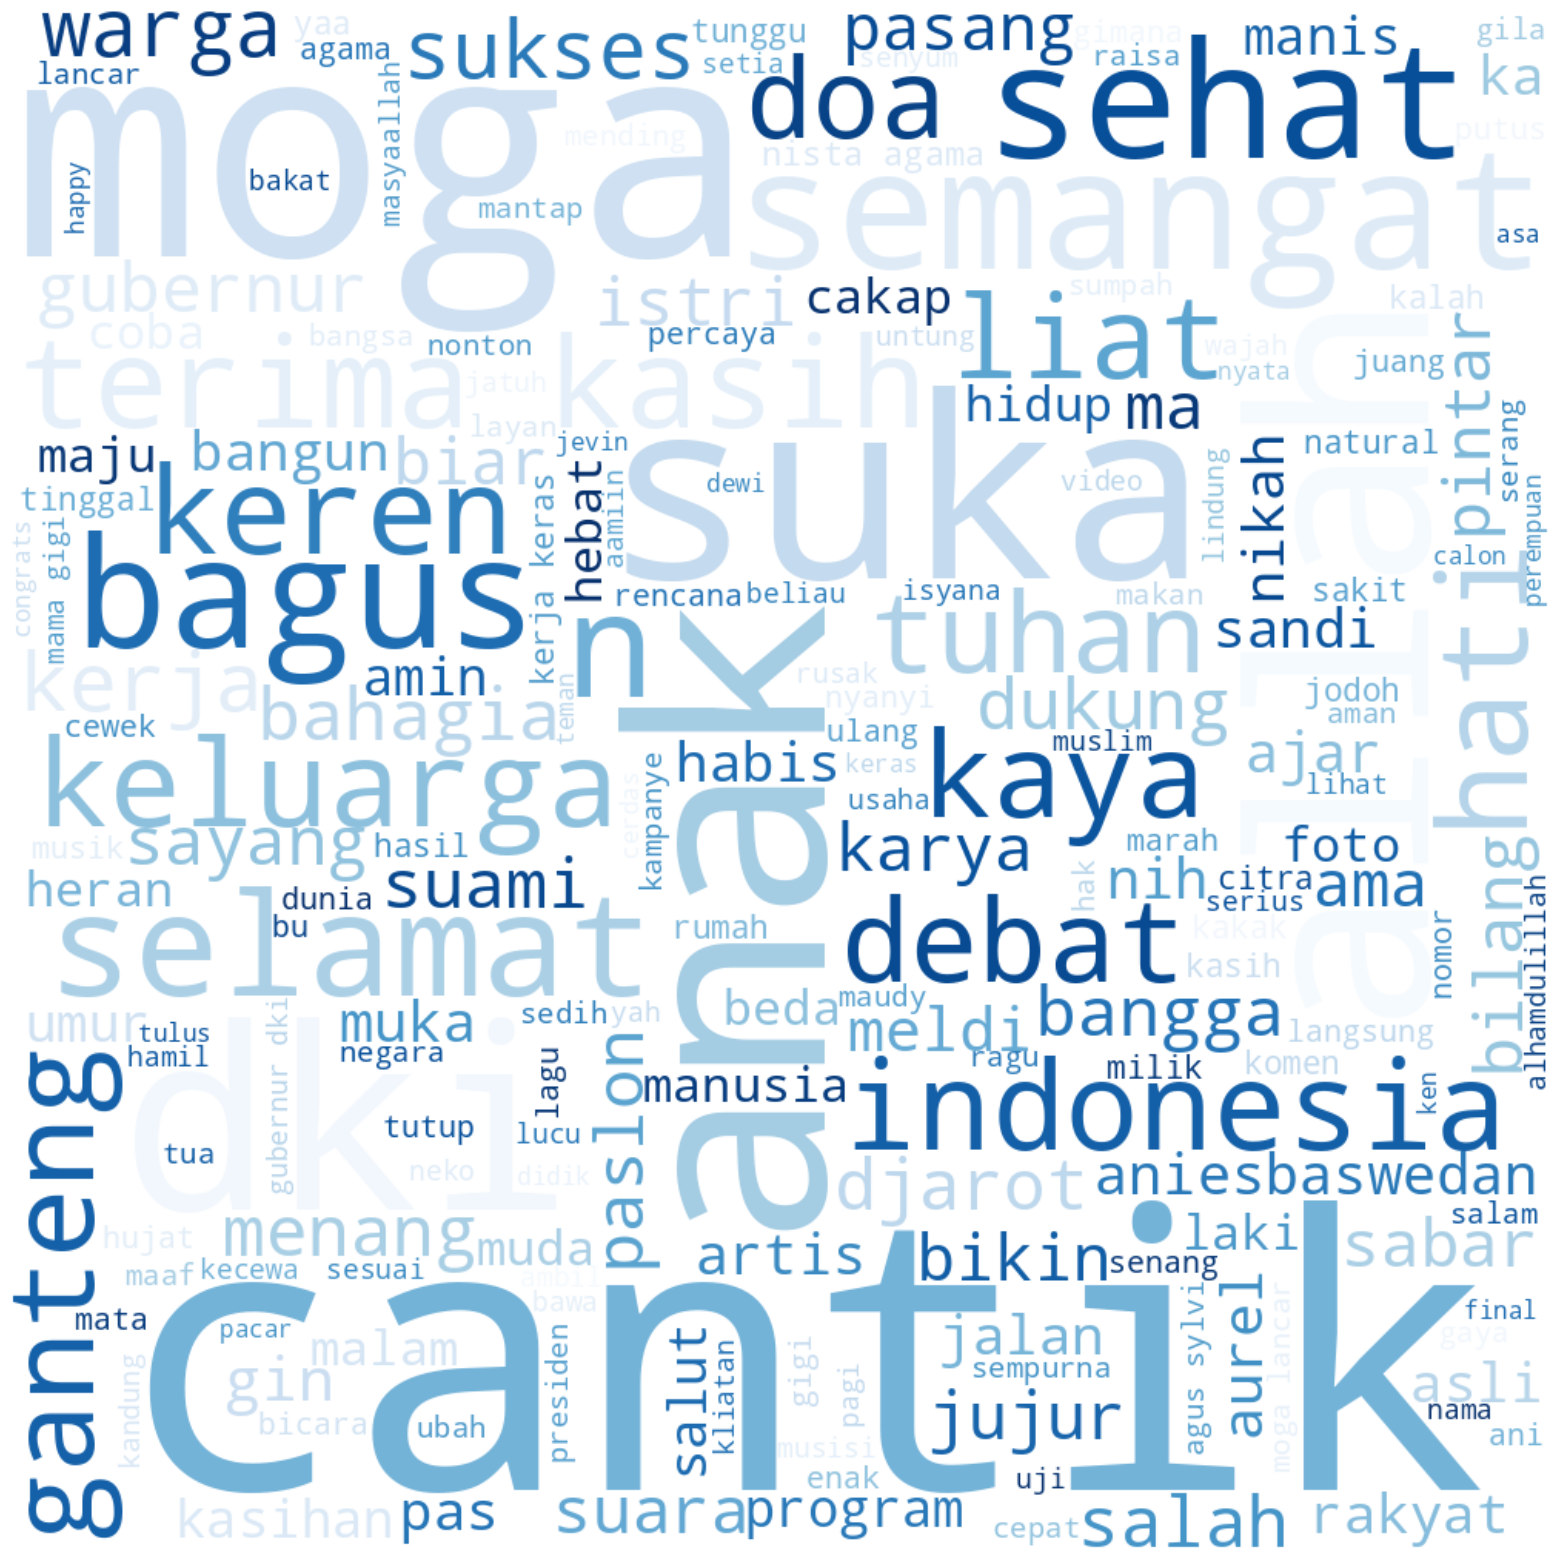

In [ ]:
# value 0
trains0=df[df['label']==0]
all_text=' '.join(word for word in trains0['Komentar'])
word_cloud=WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

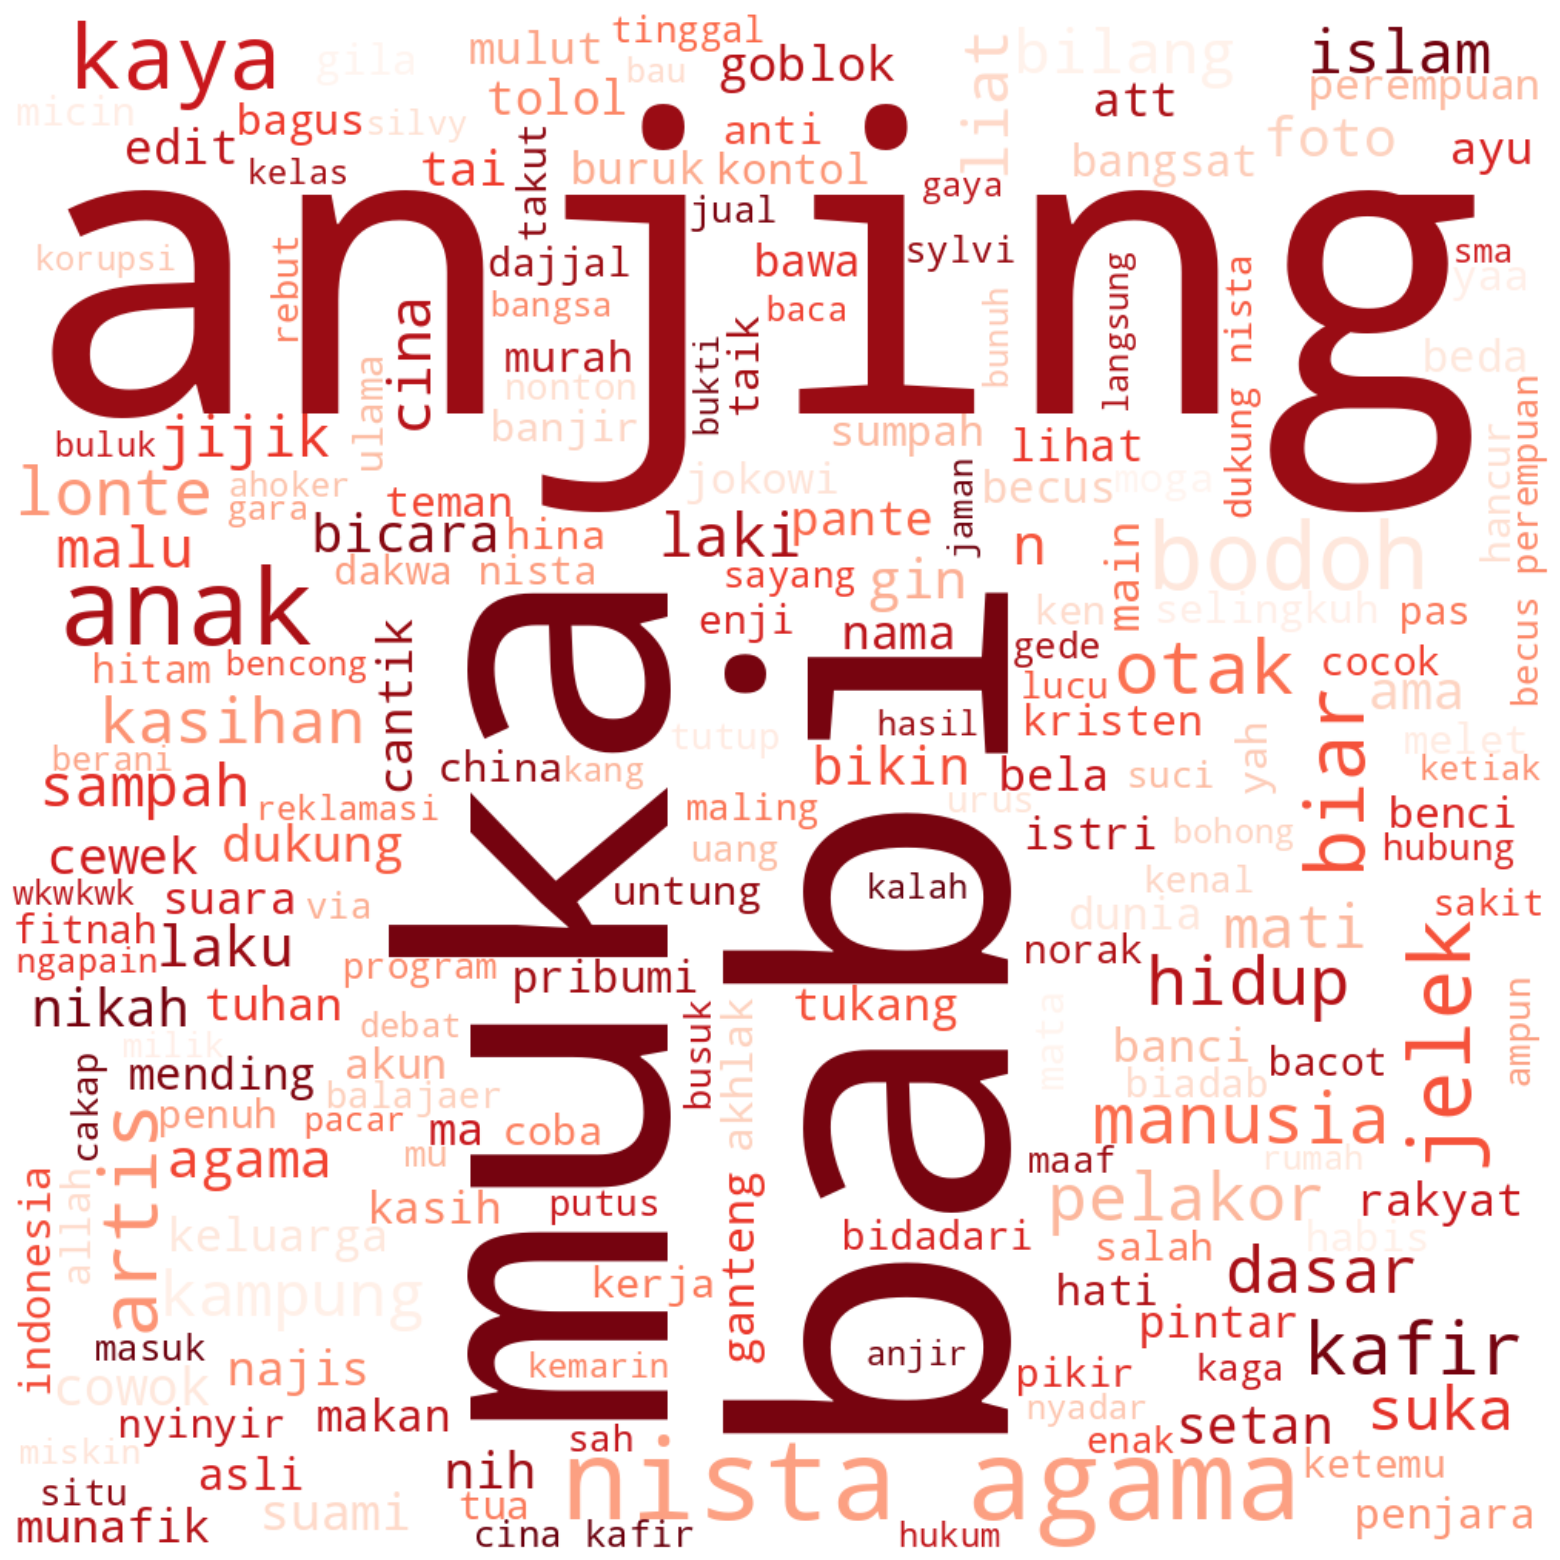

In [ ]:
# value 1
trains1=df[df['label']==1]
all_text=' '.join(word for word in trains1['Komentar'])
word_cloud=WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

## Tokenize

In [ ]:
tokenizer = Tokenizer()
def tokenize_text(text):
  tokenizer.fit_on_texts([text])
  tokenized_list = [text.split() for text in [text]]
  return tokenizer.texts_to_sequences([text])[0], tokenized_list[0]

In [ ]:
df['Komentar.tokenize'], df['Komentar.tokenize.text'] = zip(*df['Komentar'].apply(tokenize_text))

In [ ]:
df

,label,Komentar,Komentar.tokenize,Komentar.tokenize.text
0,1,sedih ngamen kawin mantan istri mahhhh pesawat...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[sedih, ngamen, kawin, mantan, istri, mahhhh, ..."
1,1,kelas nista agama ngebacot arogan sk bilang ta...,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 1...","[kelas, nista, agama, ngebacot, arogan, sk, bi..."
2,0,mrinding bagus poll dek polos smpek aw dkk,"[29, 30, 31, 32, 33, 34, 35, 36]","[mrinding, bagus, poll, dek, polos, smpek, aw,..."
3,1,omdo menteri terobos bicara ky jago,"[37, 38, 39, 40, 41, 42]","[omdo, menteri, terobos, bicara, ky, jago]"
4,1,anjing baku hantam ayo,"[43, 44, 45, 46]","[anjing, baku, hantam, ayo]"
...,...,...,...,...
1565,1,asa kemarin lengan kekar tinju ketiak hitam fo...,"[212, 216, 650, 3952, 3953, 223, 91, 46, 650, ...","[asa, kemarin, lengan, kekar, tinju, ketiak, h..."
1566,1,cocok biar hancur,"[174, 12, 286]","[cocok, biar, hancur]"
1567,1,bajing silvy,"[3955, 163]","[bajing, silvy]"
1568,1,biarin puas puasin mumpung deseu asa muda tua ...,"[591, 842, 3956, 1438, 3957, 190, 145, 130, 39...","[biarin, puas, puasin, mumpung, deseu, asa, mu..."


In [ ]:
print(tokenizer.index_word)

{1: 'agama', 2: 'anak', 3: 'cantik', 4: 'anjing', 5: 'muka', 6: 'babi', 7: 'nista', 8: 'moga', 9: 'kaya', 10: 'suka', 11: 'kasih', 12: 'biar', 13: 'liat', 14: 'artis', 15: 'bodoh', 16: 'allah', 17: 'dki', 18: 'n', 19: 'jelek', 20: 'dukung', 21: 'bilang', 22: 'kafir', 23: 'manusia', 24: 'kerja', 25: 'bagus', 26: 'hidup', 27: 'keluarga', 28: 'kasihan', 29: 'ganteng', 30: 'hati', 31: 'indonesia', 32: 'sehat', 33: 'otak', 34: 'semangat', 35: 'islam', 36: 'tuhan', 37: 'suami', 38: 'gin', 39: 'laki', 40: 'ama', 41: 'terima', 42: 'bikin', 43: 'nikah', 44: 'selamat', 45: 'nih', 46: 'foto', 47: 'istri', 48: 'debat', 49: 'dasar', 50: 'cina', 51: 'kampung', 52: 'suara', 53: 'salah', 54: 'keren', 55: 'pelakor', 56: 'gubernur', 57: 'lonte', 58: 'pintar', 59: 'bicara', 60: 'rakyat', 61: 'bahagia', 62: 'jijik', 63: 'bangga', 64: 'asli', 65: 'sayang', 66: 'laku', 67: 'cewek', 68: 'malu', 69: 'doa', 70: 'menang', 71: 'mati', 72: 'djarot', 73: 'perempuan', 74: 'dunia', 75: 'beda', 76: 'habis', 77: 'samp

In [ ]:
file_name = 'processed_dataset_w2vec.xlsx'
df.to_excel(file_name)

# **Word2vec**

In [ ]:
word2vec_model = Word2Vec.load("idwiki_word2vec_300.model") # Model Sudah dilatih menggunakan cbow

vector = word2vec_model.wv['kata']

In [ ]:
# Check skip-gram atau cbow
if word2vec_model.sg == 1:
    print("Skip-gram.")
elif word2vec_model.sg == 0:
    print("CBOW.")
else:
    print("unknown.")

CBOW.


In [ ]:
word2vec_model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['Komentar.tokenize.text'] , df['label'], test_size=0.3, stratify=df['label'],
                                                    random_state=30)

def get_word_vectors(tokens_list):
    vectors = []
    for tokens in tokens_list:
        word_vectors = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
        if word_vectors:
            mean_vector = np.mean(word_vectors, axis=0)
            vectors.append(mean_vector)
        else:
            vectors.append(np.zeros(300))
    return np.array(vectors)

x_train_word2vec = get_word_vectors(x_train)
x_test_word2vec = get_word_vectors(x_test)

In [ ]:
x_train_word2vec
x_test_word2vec

array([[ 0.18248938,  1.2239879 , -0.35775208, ...,  0.43992433,
         0.7240896 ,  0.40294155],
       [-0.3999601 ,  0.68649554,  0.46387896, ...,  0.44830862,
         0.7051469 ,  0.8522919 ],
       [-0.07323163,  0.35100204, -0.04320541, ...,  0.27997887,
        -0.49018022,  0.02913311],
       ...,
       [-0.578235  ,  0.8497867 ,  0.42849007, ..., -0.4792662 ,
        -0.5942144 ,  0.17898852],
       [-0.12241314,  0.6115196 ,  0.18634753, ..., -0.7037393 ,
        -0.3418451 ,  0.08325115],
       [ 0.49820462,  0.325936  , -0.48928928, ...,  0.6391953 ,
         0.08881215, -0.4699688 ]], dtype=float32)

# **LSTM**

In [ ]:
# Convert label ke format binary
y_train_binary = np.array(y_train)
y_test_binary = np.array(y_test)

# Reshape the input data to add the timestep dimension
x_train_reshaped = x_train_word2vec[:, np.newaxis, :]
x_test_reshaped = x_test_word2vec[:, np.newaxis, 0, :]

# Cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

cv_scores = []
cv_precision_scores = []
cv_recall_scores = []
cv_f1_scores = []

for train_index, val_index in kfold.split(x_train_reshaped, y_train_binary):
    x_train_fold, x_val_fold = x_train_reshaped[train_index], x_train_reshaped[val_index]
    y_train_fold, y_val_fold = y_train_binary[train_index], y_train_binary[val_index]

    model = Sequential()
    model.add(Dropout(0.5, input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2])))
    model.add(LSTM(units=32))
    model.add(Dropout(0.8))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train_fold, y_train_fold, epochs=200, batch_size=32, validation_data=(x_val_fold, y_val_fold), verbose=2)
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    # Evaluasi model di validation set
    _, accuracy = model.evaluate(x_val_fold, y_val_fold)
    cv_scores.append(accuracy)

    # Predict di validation set
    y_val_pred = model.predict(x_val_fold)
    y_val_pred_binary = np.round(y_val_pred).flatten()

    val_precision = precision_score(y_val_fold, y_val_pred_binary)
    val_recall = recall_score(y_val_fold, y_val_pred_binary)
    val_f1 = f1_score(y_val_fold, y_val_pred_binary)

    cv_precision_scores.append(val_precision)
    cv_recall_scores.append(val_recall)
    cv_f1_scores.append(val_f1)

# Calculate mean and standard deviation of evaluation metrics
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

mean_precision = np.mean(cv_precision_scores)
std_precision = np.std(cv_precision_scores)

mean_recall = np.mean(cv_recall_scores)
std_recall = np.std(cv_recall_scores)

mean_f1 = np.mean(cv_f1_scores)
std_f1 = np.std(cv_f1_scores)

print("x_test_reshaped shape:", x_test_reshaped.shape)
print("Expected input shape:", model.input_shape)

test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test_binary)

y_test_pred = model.predict(x_test_reshaped)
y_test_pred_binary = np.round(y_test_pred).flatten()

test_precision = precision_score(y_test_binary, y_test_pred_binary)
test_recall = recall_score(y_test_binary, y_test_pred_binary)
test_f1 = f1_score(y_test_binary, y_test_pred_binary)

# Evaluasi model di test set
print("Cross-Validation Accuracy: {:.4f} (+/- {:.4f})".format(mean_cv_score, std_cv_score))
print("Cross-Validation Precision: {:.4f} (+/- {:.4f})".format(mean_precision, std_precision))
print("Cross-Validation Recall: {:.4f} (+/- {:.4f})".format(mean_recall, std_recall))
print("Cross-Validation F1 Score: {:.4f} (+/- {:.4f})".format(mean_f1, std_f1))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

Epoch 1/200
28/28 - 3s - loss: 0.7008 - accuracy: 0.5301 - val_loss: 0.6447 - val_accuracy: 0.6818 - 3s/epoch - 104ms/step
Epoch 2/200
28/28 - 0s - loss: 0.6566 - accuracy: 0.6109 - val_loss: 0.6018 - val_accuracy: 0.7455 - 123ms/epoch - 4ms/step
Epoch 3/200
28/28 - 0s - loss: 0.6301 - accuracy: 0.6416 - val_loss: 0.5732 - val_accuracy: 0.7273 - 129ms/epoch - 5ms/step
Epoch 4/200
28/28 - 0s - loss: 0.6099 - accuracy: 0.6598 - val_loss: 0.5464 - val_accuracy: 0.7409 - 140ms/epoch - 5ms/step
Epoch 5/200
28/28 - 0s - loss: 0.5718 - accuracy: 0.7065 - val_loss: 0.5272 - val_accuracy: 0.7409 - 127ms/epoch - 5ms/step
Epoch 6/200
28/28 - 0s - loss: 0.5653 - accuracy: 0.7076 - val_loss: 0.5134 - val_accuracy: 0.7409 - 133ms/epoch - 5ms/step
Epoch 7/200
28/28 - 0s - loss: 0.5492 - accuracy: 0.7304 - val_loss: 0.4995 - val_accuracy: 0.7409 - 129ms/epoch - 5ms/step
Epoch 8/200
28/28 - 0s - loss: 0.5411 - accuracy: 0.7258 - val_loss: 0.4918 - val_accuracy: 0.7409 - 132ms/epoch - 5ms/step
Epoch 9/2

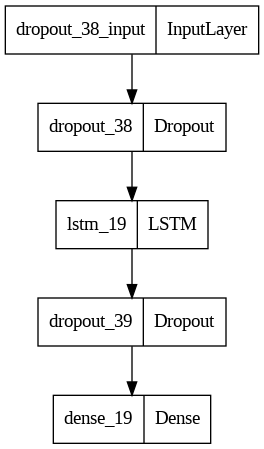

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_38 (Dropout)        (None, 1, 300)            0         
                                                                 
 lstm_19 (LSTM)              (None, 32)                42624     
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 42657 (166.63 KB)
Trainable params: 42657 (166.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


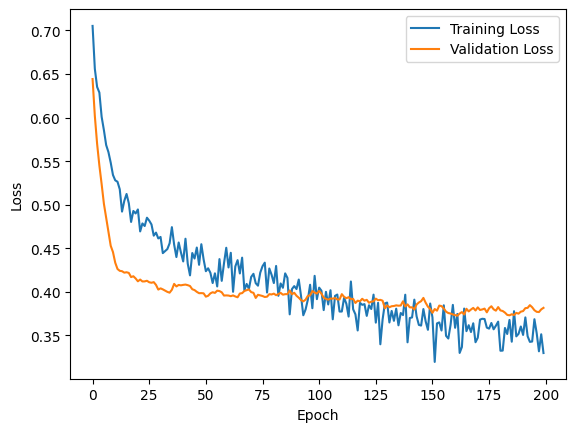

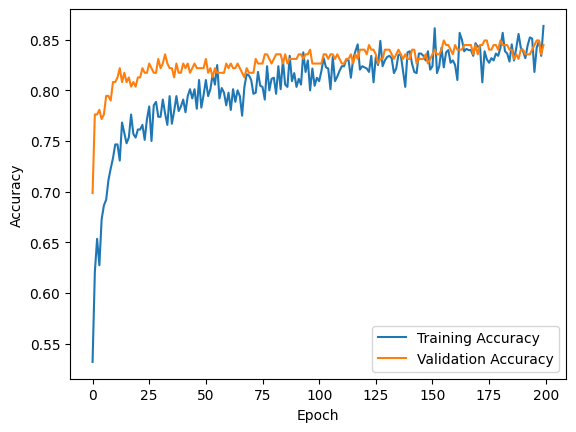

In [ ]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

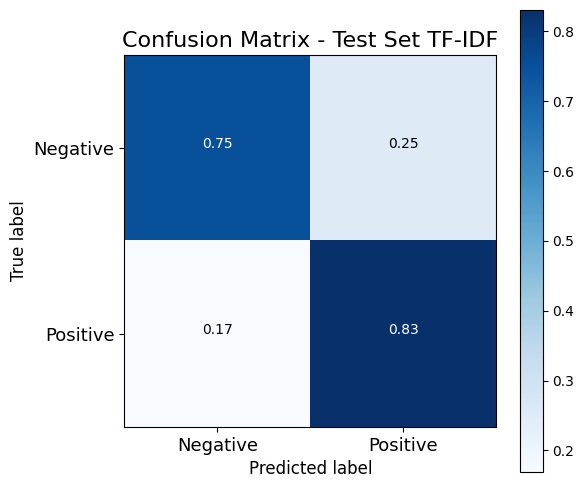

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

# Create confusion matrix
cnf_matrix = confusion_matrix(y_test_binary, y_test_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'], title='Confusion Matrix - Test Set TF-IDF')
plt.show()

In [ ]:
x_test_word2vec = x_test_word2vec.reshape((x_test_word2vec.shape[0], x_train_fold.shape[1], x_train_fold.shape[2]))

In [ ]:
predicted_probabilities = model.predict(x_test_word2vec)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

15/15 [==============================] - 0s 2ms/step


In [ ]:
predicted_labels_reshaped = predicted_labels.reshape(-1)

In [ ]:
# Assuming y_test and predicted_labels are numpy arrays or similar
detected_indices = np.where((y_test == 1) & (predicted_labels_reshaped == 1))[0]

# Displaying a few detected cyberbullying comments
for idx in detected_indices[:5]:  # Displaying the first 5 for demonstration
    print(x_test.iloc[idx])

['perilaku', 'babi', 'jokoanwar', 'benci', 'bau', 'islam', 'cocok', 'sibonekakayu']
['ahmaddhaniprast', 'babi', 'anjing', 'mampus', 'kalah', 'jatuh', 'miskin']
['anjing', 'foto', 'anjing']
['beli', 'model', 'murah', 'barang', 'murah']
['ah', 'min', 'suka', 'akun', 'nih', 'berita', 'basi', 'liat', 'min', 'kellen', 'amora', 'jingkrak', 'saring', 'min', 'biar', 'berita', 'blunder', 'posting', 'kd', 'posting', 'videon', 'kellen', 'ma', 'amora', 'joget', 'ma', 'arsya', 'arsyi']


In [ ]:
y_test

409     1
1170    1
336     0
88      1
826     0
       ..
168     0
1371    0
374     1
474     0
770     0
Name: label, Length: 471, dtype: int64

In [ ]:
predicted_labels

array([[1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
    

In [ ]:
def preprocess_unseen_data(text):
    text = data_cleansing(text)
    text = ubah_singkatan(text)
    text = stopwords(text)
    text = stemming(text)
    return text

def preprocess_and_predict(unseen_data):
    preprocessed_data = preprocess_unseen_data(unseen_data)
    tfidf_features = vectorizer.transform([preprocessed_data])
    tfidf_features_array = tfidf_features.toarray()
    num_features = tfidf_features_array.shape[1]
    tfidf_features_lstm = np.reshape(tfidf_features_array, (1, 1, num_features))
    predictions = model.predict(tfidf_features_lstm)
    predicted_classes = (predictions > 0.6).astype(int)
    if predictions > 0.6 :
      print("Cyberbullying")
    else:
      print("Tidak Cyberbullying")

    return predicted_classes[0], predictions

In [ ]:
file_name1 = 'y_test.xlsx'
y_test.to_excel(file_name1)

In [ ]:
predicted_labels_df = pd.DataFrame(predicted_labels)
file_name2 = 'predicted_labels.xlsx'
predicted_labels_df.to_excel(file_name2)

In [ ]:
print('test')

test
